<a href="https://colab.research.google.com/github/Hrituja/Stock-Market-Prediction/blob/master/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()

Saving FileName2.csv to FileName2.csv


In [0]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['FileName2.csv']))
df.head()

,Unnamed: 0,Headline,Timestamp,result,ms_today,ms_tomorrow,normalized_headline
0,24,Sensex falls ahead of GST; set for first month...,2017-06-30,True,1,0,sensex falls ahead of gst; set for first month...
1,46,"Sensex trades flat, Nifty below 9,500; broader...",2017-06-30,True,1,0,"sensex trades flat, nifty below 9,500; broader..."
2,89,"Sensex trades lower, Nifty below 9,500; BSE Mi...",2017-06-30,True,1,0,"sensex trades lower, nifty below 9,500; bse mi..."
3,90,"Market in wait and watch, Sensex slips over 15...",2017-06-30,True,1,0,"market in wait and watch, sensex slips over 15..."
4,112,"Markets Live: Sensex, Nifty fall steeply ahead...",2017-06-30,True,1,0,"markets live: sensex, nifty fall steeply ahead..."


In [0]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = train_test_split(df["Headline"].values, df['ms_today'].values, random_state=42)

In [0]:
vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 80  # Max number of words kept at the end of each text

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

In [0]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline
import numpy as np


batch_size = 64
max_features = vocab_size + 1

def create_model(max_features):
    """ Model creation function: returns a compiled Bidirectional LSTM"""
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=10, batch_size=batch_size, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(texts_train, y_train);

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
14802/14802 [==============================] - 101s 7ms/step - loss: 0.6334 - accuracy: 0.6465
Epoch 2/10
14802/14802 [==============================] - 100s 7ms/step - loss: 0.5644 - accuracy: 0.7106
Epoch 3/10
14802/14802 [==============================] - 100s 7ms/step - loss: 0.5262 - accuracy: 0.7354
Epoch 4/10
14802/14802 [==============================] - 100s 7ms/step - loss: 0.4991 - accuracy: 0.7553
Epoch 5/10
14802/14802 [==============================] - 100s 7ms/step - loss: 0.4737 - accuracy: 0.7664
Epoch 6/10
14802/14802 [==============================] - 100s 7ms/step - loss: 0.4562 - accuracy: 0.7781
Epoch 7/10
14802/14802 [==============================] - 100s 7ms/step - loss: 0.4402 - accuracy: 0.7814
Epoch 8/10
14802/14802 [==============================] - 100s 7ms/step - loss: 0.4256 - accuracy: 0.7921
Epoch 9/10
14802/14802 [==============================] - 100s 7ms/step - loss: 0.4113 - accuracy: 0.7999
Epoch 10/10
14802/14802 [=====================

In [0]:
from sklearn import metrics
print('Computing predictions on test set...')
y_preds = pipeline.predict(texts_test)

print('Test accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))

Computing predictions on test set...
4934/4934 [==============================] - 9s 2ms/step
Test accuracy: 71.34 %


In [0]:
# We choose a sample from test set
idx = 1000
text_sample = texts_test[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 10000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

Sample 1000: last 10000 words (only part used by the model)
--------------------------------------------------
Live: Sensex Edges Higher; Bank of Baroda, SBI Surge
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
Probability(positive) = 0.47289026
True class: negative


In [0]:
!pip install lime

     |████████████████████████████████| 276kB 2.6MB/s 
     |████████████████████████████████| 2.0MB 12.2MB/s 
  Created wheel for lime: filename=lime-0.2.0.0-cp36-none-any.whl size=284181 sha256=76286dfe91228b4905467b68551b5d81d58131762511ede573e40adc739e2f4d
  Stored in directory: /root/.cache/pip/wheels/22/f2/ec/e5ebd07348b2b1ac722e91c2f549fcc220f7d5f25497a61232
Successfully built lime
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


5000/5000 [==============================] - 9s 2ms/step


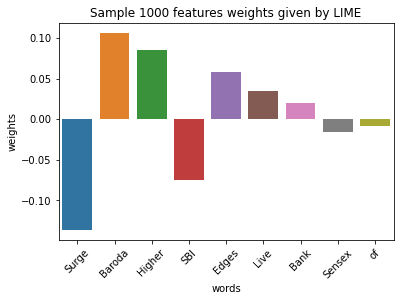

In [0]:
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt


explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=100)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));